In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [2]:
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch


2025-07-28 17:28:10.151636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753723690.417363      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753723690.497741      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
test = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')

print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (2029, 9), Test shape: (10, 8)


*Preprocess Text*

# Tokenizer & Model Name

In [5]:
def build_input_text(row):
    return (
        f"Rule: {row['rule']} "
        f"Positive Examples: {row['positive_example_1']} {row['positive_example_2']} "
        f"Negative Examples: {row['negative_example_1']} {row['negative_example_2']} "
        f"Comment: {row['body']}"
    )

train['input_text'] = train.apply(build_input_text, axis=1)
test['input_text'] = test.apply(build_input_text, axis=1)


In [6]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode(examples):
    return tokenizer(examples['input_text'], truncation=True, padding='max_length', max_length=256)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# Cross-Validation Setup

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))


In [8]:
os.environ["WANDB_DISABLED"] = "true"
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"  # Disable W&B
)


# . Training Loop for 5 Folds

In [9]:
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['rule_violation'])):
    print(f"***** Fold {fold+1} *****")
    
    train_fold = train.iloc[train_idx]
    val_fold = train.iloc[val_idx]
    
    # Convert to HF Dataset
    hf_train = Dataset.from_pandas(train_fold[['input_text', 'rule_violation']])
    hf_val = Dataset.from_pandas(val_fold[['input_text', 'rule_violation']])
    hf_test = Dataset.from_pandas(test[['input_text']])
    
    # Tokenize
    hf_train = hf_train.map(encode, batched=True)
    hf_val = hf_val.map(encode, batched=True)
    hf_test = hf_test.map(encode, batched=True)
    
    hf_train = hf_train.rename_column('rule_violation', 'labels')
    hf_val = hf_val.rename_column('rule_violation', 'labels')
    
    hf_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    hf_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    hf_test.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    
    # Load Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./fold_{fold+1}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        save_total_limit=1
    )
    
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
        auc = roc_auc_score(labels, probs)
        return {"roc_auc": auc}
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_train,
        eval_dataset=hf_val,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    
    # Validation Predictions
    val_preds = trainer.predict(hf_val).predictions
    val_probs = torch.softmax(torch.tensor(val_preds), dim=-1)[:, 1].numpy()
    oof_preds[val_idx] = val_probs
    
    # Test Predictions
    test_preds_fold = trainer.predict(hf_test).predictions
    test_probs_fold = torch.softmax(torch.tensor(test_preds_fold), dim=-1)[:, 1].numpy()
    test_preds += test_probs_fold / 5


***** Fold 1 *****


Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.695500
100,0.693500
150,0.688000
200,0.691900
250,0.702300
300,0.693900
350,0.694300
400,0.694000


***** Fold 2 *****


Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.694800
100,0.693800
150,0.691300
200,0.691300
250,0.685800
300,0.688400
350,0.672200
400,0.662200


***** Fold 3 *****


Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.691100
100,0.691000
150,0.693300
200,0.689400
250,0.675900
300,0.681400
350,0.675200
400,0.680400


***** Fold 4 *****


Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.688200
100,0.693600
150,0.696600
200,0.682600
250,0.693900
300,0.677500
350,0.684000
400,0.682600


***** Fold 5 *****


Map:   0%|          | 0/1624 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.689900
100,0.687800
150,0.694900
200,0.695800
250,0.685900
300,0.671600
350,0.690800
400,0.678800


# Out-of-Fold Score

In [10]:
print("OOF ROC-AUC:", roc_auc_score(train['rule_violation'], oof_preds))


OOF ROC-AUC: 0.5846882902565558


# Visualization of Training Progress

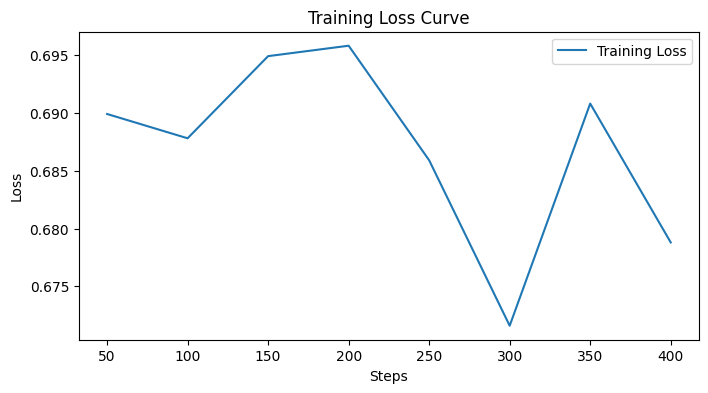

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(trainer):
    logs = trainer.state.log_history
    steps = [log["step"] for log in logs if "loss" in log]
    losses = [log["loss"] for log in logs if "loss" in log]
    
    plt.figure(figsize=(8, 4))
    plt.plot(steps, losses, label='Training Loss')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

plot_training_history(trainer)


# Distribution of Predictions

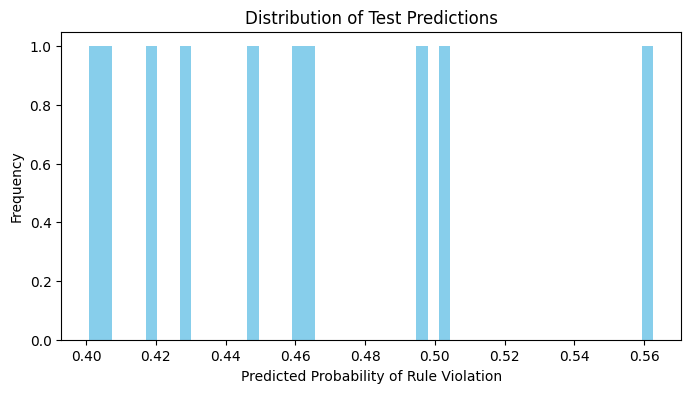

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(test_preds, bins=50, color='skyblue')
plt.title("Distribution of Test Predictions")
plt.xlabel("Predicted Probability of Rule Violation")
plt.ylabel("Frequency")
plt.show()


# ROC Curve (Validation)

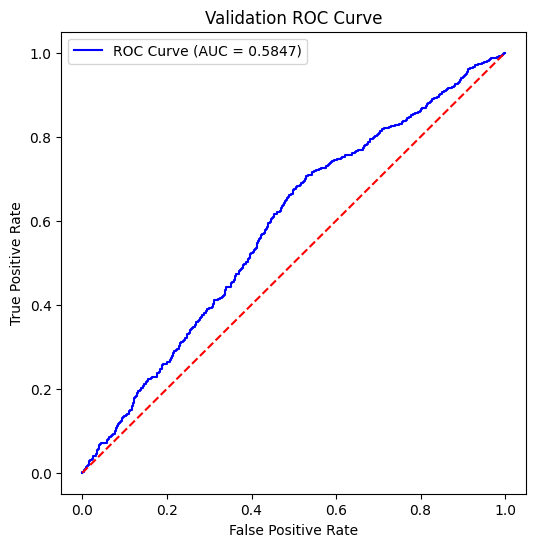

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(train['rule_violation'], oof_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.show()


# Submission

In [14]:
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'rule_violation': test_preds
})
submission.to_csv('submission.csv', index=False)
print(submission.head())


   row_id  rule_violation
0    2029        0.405566
1    2030        0.562579
2    2031        0.495292
3    2032        0.465449
4    2033        0.427754
